In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

/home/qlyu/mambaforge/envs/bbbroutine/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(0)

In [3]:
# functions (the teacher wrote for you to use later)
def rot2d(x, y, theta, unit='degree'):
    """ rotate data points defined by `x` and `y` by `theta` degree
    """
    a = np.vstack([x,y]).T
    if unit == 'degree':
        theta = theta*np.pi/180 # convert to radian

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    ar = a.dot(R.T)
    return ar[:,0], ar[:,1]

def st_scatter(x, y, gexp=None, vmax_p=98, unit_norm=False, 
               title='', s=1, cbar_label='', output='', cmap='rocket_r', axis_off=True, 
               vmin=None, **cbar_kwargs):
    """customized scatter plot -- yesterday's progress
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
  
    fig, ax = plt.subplots(figsize=(10,8))
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        if unit_norm:
            rgexp = gexp/vmax
            g = ax.scatter(x, y, c=rgexp, s=s, edgecolor='none', vmin=vmin, vmax=1, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
            title = title + f" (max {vmax:.2g} at {vmax_p:.2g} pctl)"
        else:
            g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    if output:
        powerplots.savefig_autodate(fig, output)
        
    return 

# visualize clusters
def plot_cluster(clsts, x, y, ux, uy, s=1, axis_off=True):
    """this assumes `clsts` is a integer that starts from 0
    """
    from matplotlib import colors
  
    unq_clsts, inv = np.unique(clsts, return_inverse=True)
    n_unq = len(unq_clsts)
    # colors = np.array(sns.color_palette('husl', n_unq))
    # c_vec = colors[inv]
  
    cmap = plt.cm.jet
    norm = colors.BoundaryNorm(np.arange(-0.5, n_unq, 1), cmap.N)
  
    fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
    
    ax = axs[0]
    g = ax.scatter(x, y, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('XY (spatial distribution)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
    
    ax = axs[1]
    ax.scatter(ux, uy, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('UMAP (molecular similarity)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
  
    fig.colorbar(g, ax=ax, label='clusters', ticks=np.arange(n_unq), shrink=0.7)
    return fig, axs

In [4]:
outdir = "/data/qlyu/v1/results_merfish/plots_230623"
outdatadir = "/data/qlyu/v1/results_merfish"
!mkdir -p $outdir

In [5]:
adata = ad.read('/data/qlyu/v1/results_merfish/ant_reg0_ctxglut_230623.h5ad')
adata

AnnData object with n_obs × n_vars = 11615 × 500
    obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'PolyT_raw', 'PolyT_high_pass', 'DAPI_raw', 'DAPI_high_pass', 'leiden_r0.1', 'leiden_spatial_r0.02', 'leiden_r0.2', 'leiden_r0.5'
    uns: 'leiden', 'neighbors'
    obsm: 'blanks', 'pca', 'umap', 'xy'
    layers: 'norm'
    obsp: 'connectivities', 'distances'

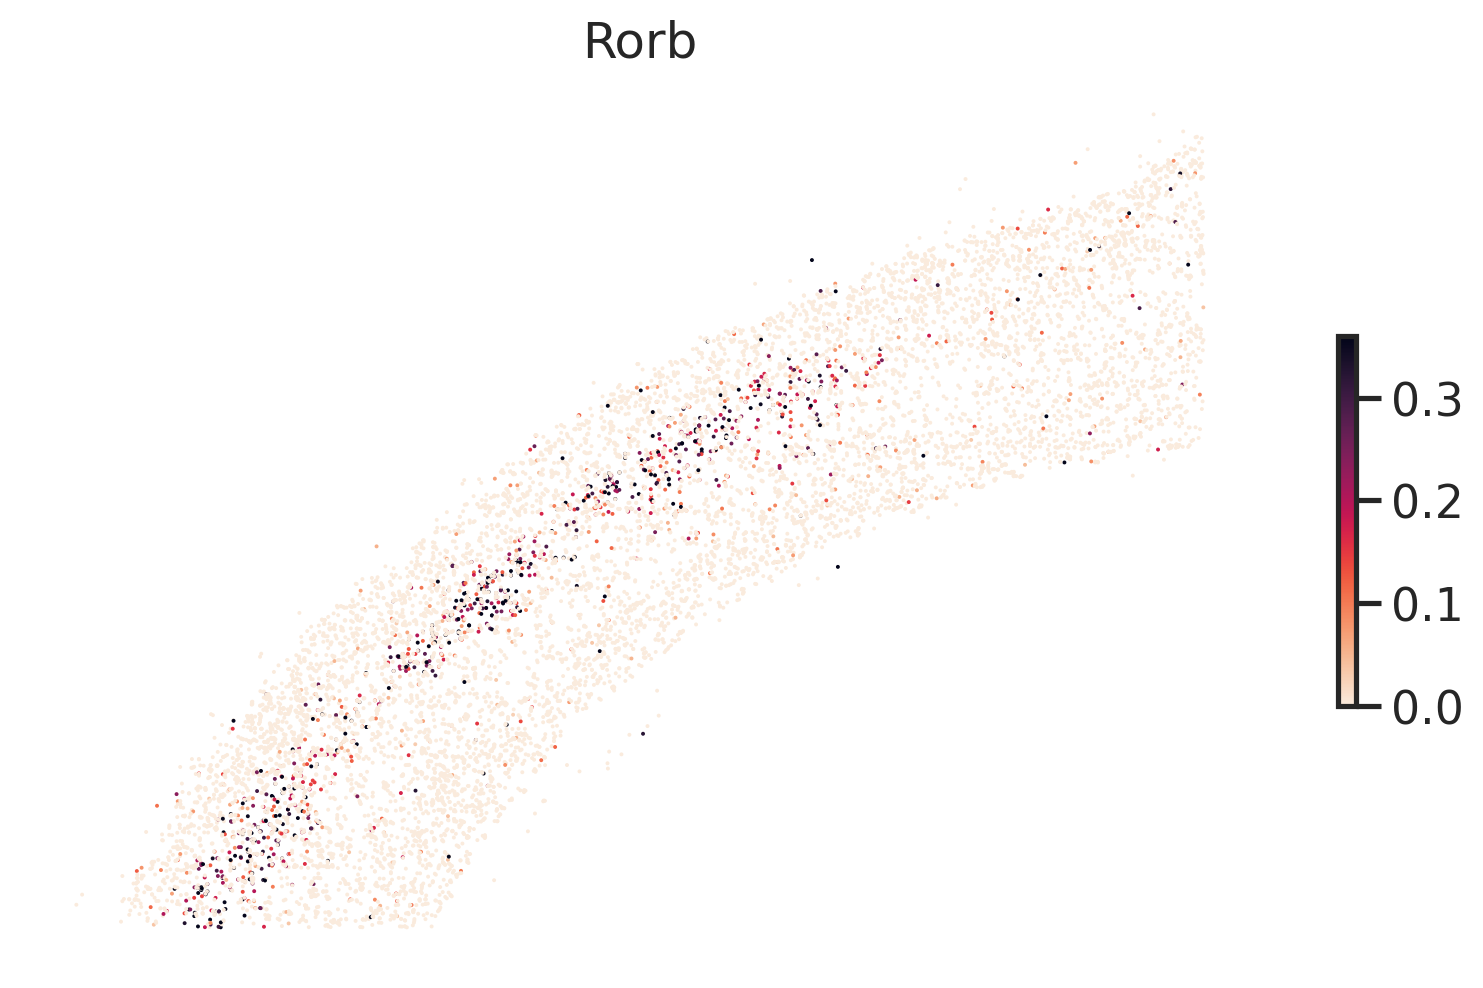

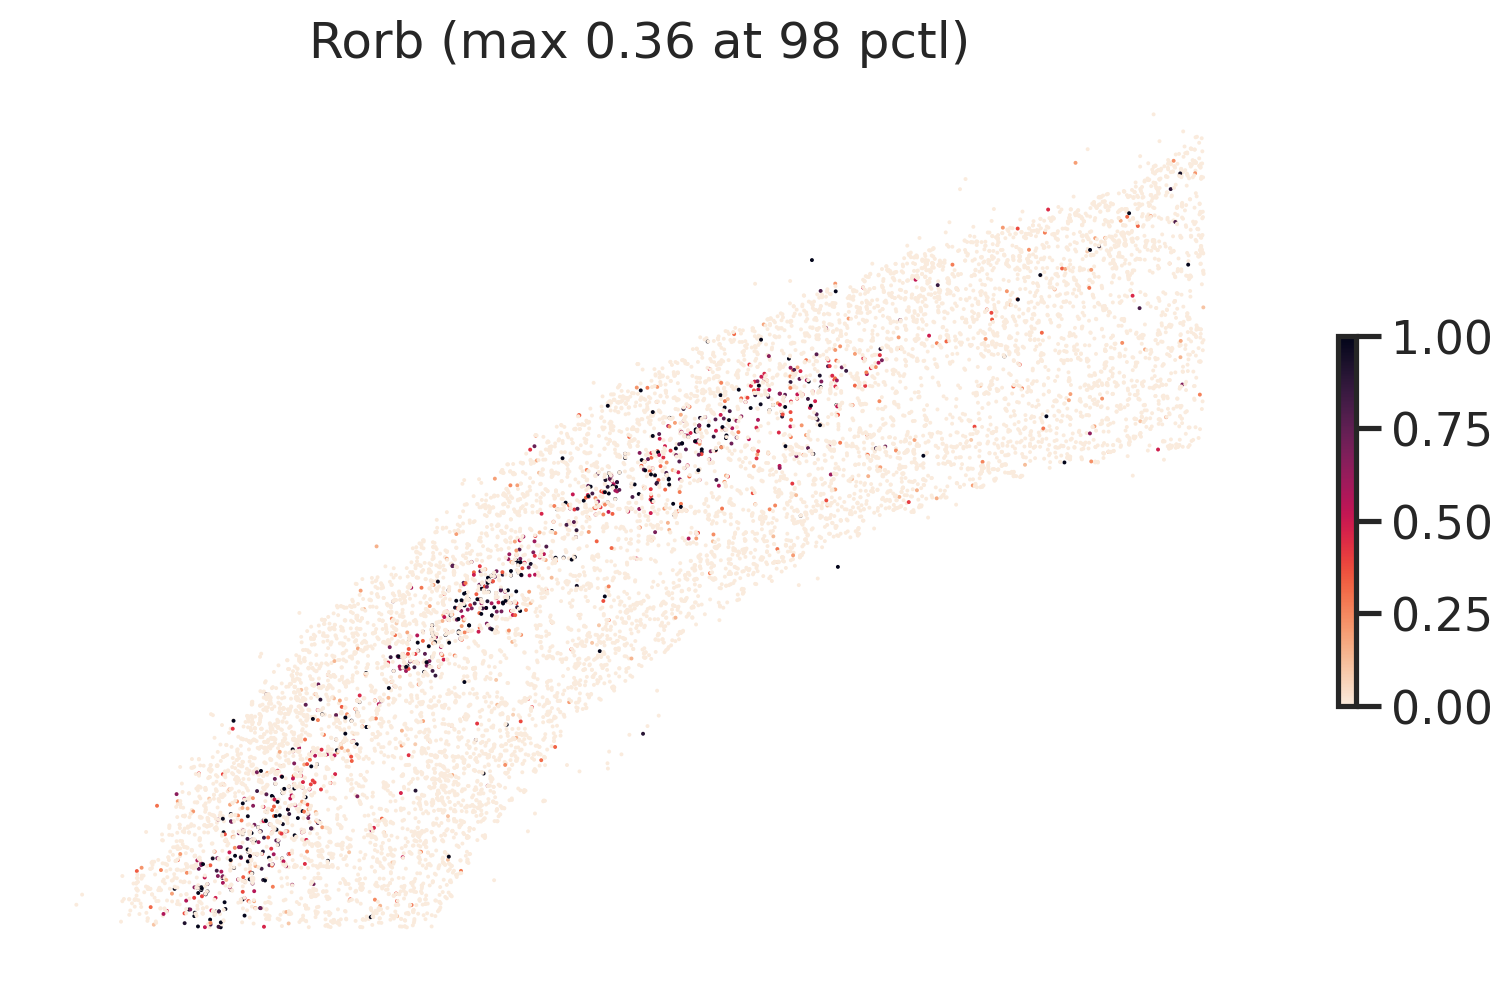

In [6]:
gn = 'Rorb'

x = adata.obs['x']
y = adata.obs['y']
ux = adata.obsm['umap'][:,0]
uy = adata.obsm['umap'][:,1]

g = np.log10(1+adata[:,gn].layers['norm'])

st_scatter(x, y, gexp=g, s=2, title=gn)
st_scatter(x, y, gexp=g, s=2, title=gn, unit_norm=True)
# st_scatter(ux, uy, gexp=g, s=2, title=gn)

In [7]:
# copy my code 

In [8]:
from scipy import spatial

def p_to_curve(query_point, pia_curve):
    """return the distance from a point to a set curve
    measure distance to each segment and take the min
    """
    tan_vec = pia_curve[1:] - pia_curve[:-1]
    # unit
    tan_vec = tan_vec/np.linalg.norm(tan_vec, axis=1).reshape(-1,1)
    norm_vec = tan_vec.dot(np.array([[0,-1],[1,0]]).T)
    # np.power(tan_vec[:,0],2)+np.power(tan_vec[:,1],2) # check normed

    query_vec = (query_point - pia_curve[:-1])
    d = np.min(np.abs(query_vec[:,0]*norm_vec[:,0] + query_vec[:,1]*norm_vec[:,1]))
    return d

def ps_to_curve(query_points, pia_curve):
    """return the distance from a set of points to a set curve
    """
    tan_vec = pia_curve[1:] - pia_curve[:-1]
    # unit
    tan_vec = tan_vec/np.linalg.norm(tan_vec, axis=1).reshape(-1,1)
    norm_vec = tan_vec.dot(np.array([[0,-1],[1,0]]).T)
    
    query_mtx = np.repeat(XY[:,np.newaxis,:], len(pia_curve)-1, axis=1) - pia_curve[:-1]
    ds = np.min(np.abs(query_mtx[:,:,0]*norm_vec[:,0] + query_mtx[:,:,1]*norm_vec[:,1]), axis=1)
    return ds


In [9]:
class RefLineSegs:
    """
    """
    def __init__(self, ps):
        """
        line segments defined by ps
        """
        self.ps = ps
        self.rps = ps[:-1] # reference points (exclude the last point)
        self.ns = len(ps)-1 # number of segments
        # get ts and uts
        self.calc_tan_vec()
        
        return
    
    def calc_tan_vec(self):
        """get tangent vectors
        """
        ps = self.ps 
        ts = ps[1:] - ps[:-1]
        lts = np.linalg.norm(ts, axis=1)
        uts = ts/lts.reshape(-1,1)
        nuts = uts.dot(np.array([[0,-1],[1,0]]).T)
        
        # np.power(uts[:,0],2)+np.power(uts[:,1],2) # check normed
        
        self.ts = ts # tangents
        self.uts = uts # unitary tangents
        self.nuts = nuts # norm to unitary tangents
        
        self.lts = lts # tangent lengths
        self.cumlts = np.hstack([0,np.cumsum(lts)])[:-1] # cumulative tangent lengths
        
        return 
    
    def calc_seg_len(self):
        """get the length of each segment
        """
        ts = self.ts
        
        np.linalg.norm(ts, axis=1)
        
    
    
    def ndist_to_qp(self, query_point):
        """return the distance from a point to a set curve
        measure distance to each segment and take the min
        """
        query_vec = (query_point - self.rps)
        ndist = np.min(np.abs(query_vec[:,0]*self.nuts[:,0] + query_vec[:,1]*self.nuts[:,1]))
        
        return ndist
        
    def ndist_to_qps(self, XY):
        """return the distance from a point to a set curve
        measure distance to each segment and take the min
        """
        query_mtx = np.repeat(XY[:,np.newaxis,:], self.ns, axis=1) - self.rps
        tmp = np.abs(query_mtx[:,:,0]*self.nuts[:,0] + query_mtx[:,:,1]*self.nuts[:,1])
        ndists = np.min(tmp, axis=1)
        
        return ndists
        
    def tdist_to_qps(self, XY):
        """return the distance from a point to a set curve
        adds up the distance of each segment
        """
        
        query_mtx = np.repeat(XY[:,np.newaxis,:], self.ns, axis=1) - self.rps
        tmp = np.abs(query_mtx[:,:,0]*self.nuts[:,0] + query_mtx[:,:,1]*self.nuts[:,1])
        
        # which segment
        min_seg_idx = np.argmin(tmp, axis=1)
        
        # cumsum up to the segment
        tdists = self.cumlts[min_seg_idx]
        
        
        uts = self.uts[min_seg_idx] # tangent vector for each ref point
        qs_vec = XY - self.rps[min_seg_idx] # 
        tdists_correction = qs_vec[:,0]*uts[:,0] + qs_vec[:,1]*uts[:,1]
        
        return tdists+tdists_correction
        


In [10]:
def binning(val, n):
    """
    """
    bins = np.linspace(np.min(val), np.max(val), n)
    binned = pd.cut(val, bins=bins)
    
    return bins, binned

In [11]:
meta = adata.obs

XY = meta[['x', 'y']].values

# convex hull
hull = spatial.ConvexHull(XY)
pia_vtx = hull.vertices[15:]
pia_curve = XY[pia_vtx]
pia_curve_obj = RefLineSegs(pia_curve)

# depth
meta['depth'] = pia_curve_obj.ndist_to_qps(XY)
meta['width'] = pia_curve_obj.tdist_to_qps(XY)

In [12]:
pia_curve_obj.cumlts

array([   0.        ,  178.12282424,  837.76748459, 1617.39413981,
       2245.5020766 , 2782.41330008, 3146.91434152, 3484.9388948 ,
       3670.17379315, 3930.76427341])

In [13]:
# bin it 

depth_bins, depth_binned = binning(meta['depth'].values, 20)
meta['depth_bin'] = depth_binned

width_bins, width_binned = binning(meta['width'].values, 20)
meta['width_bin'] = width_binned


Text(0.5, 1.0, 'P28 anterior')

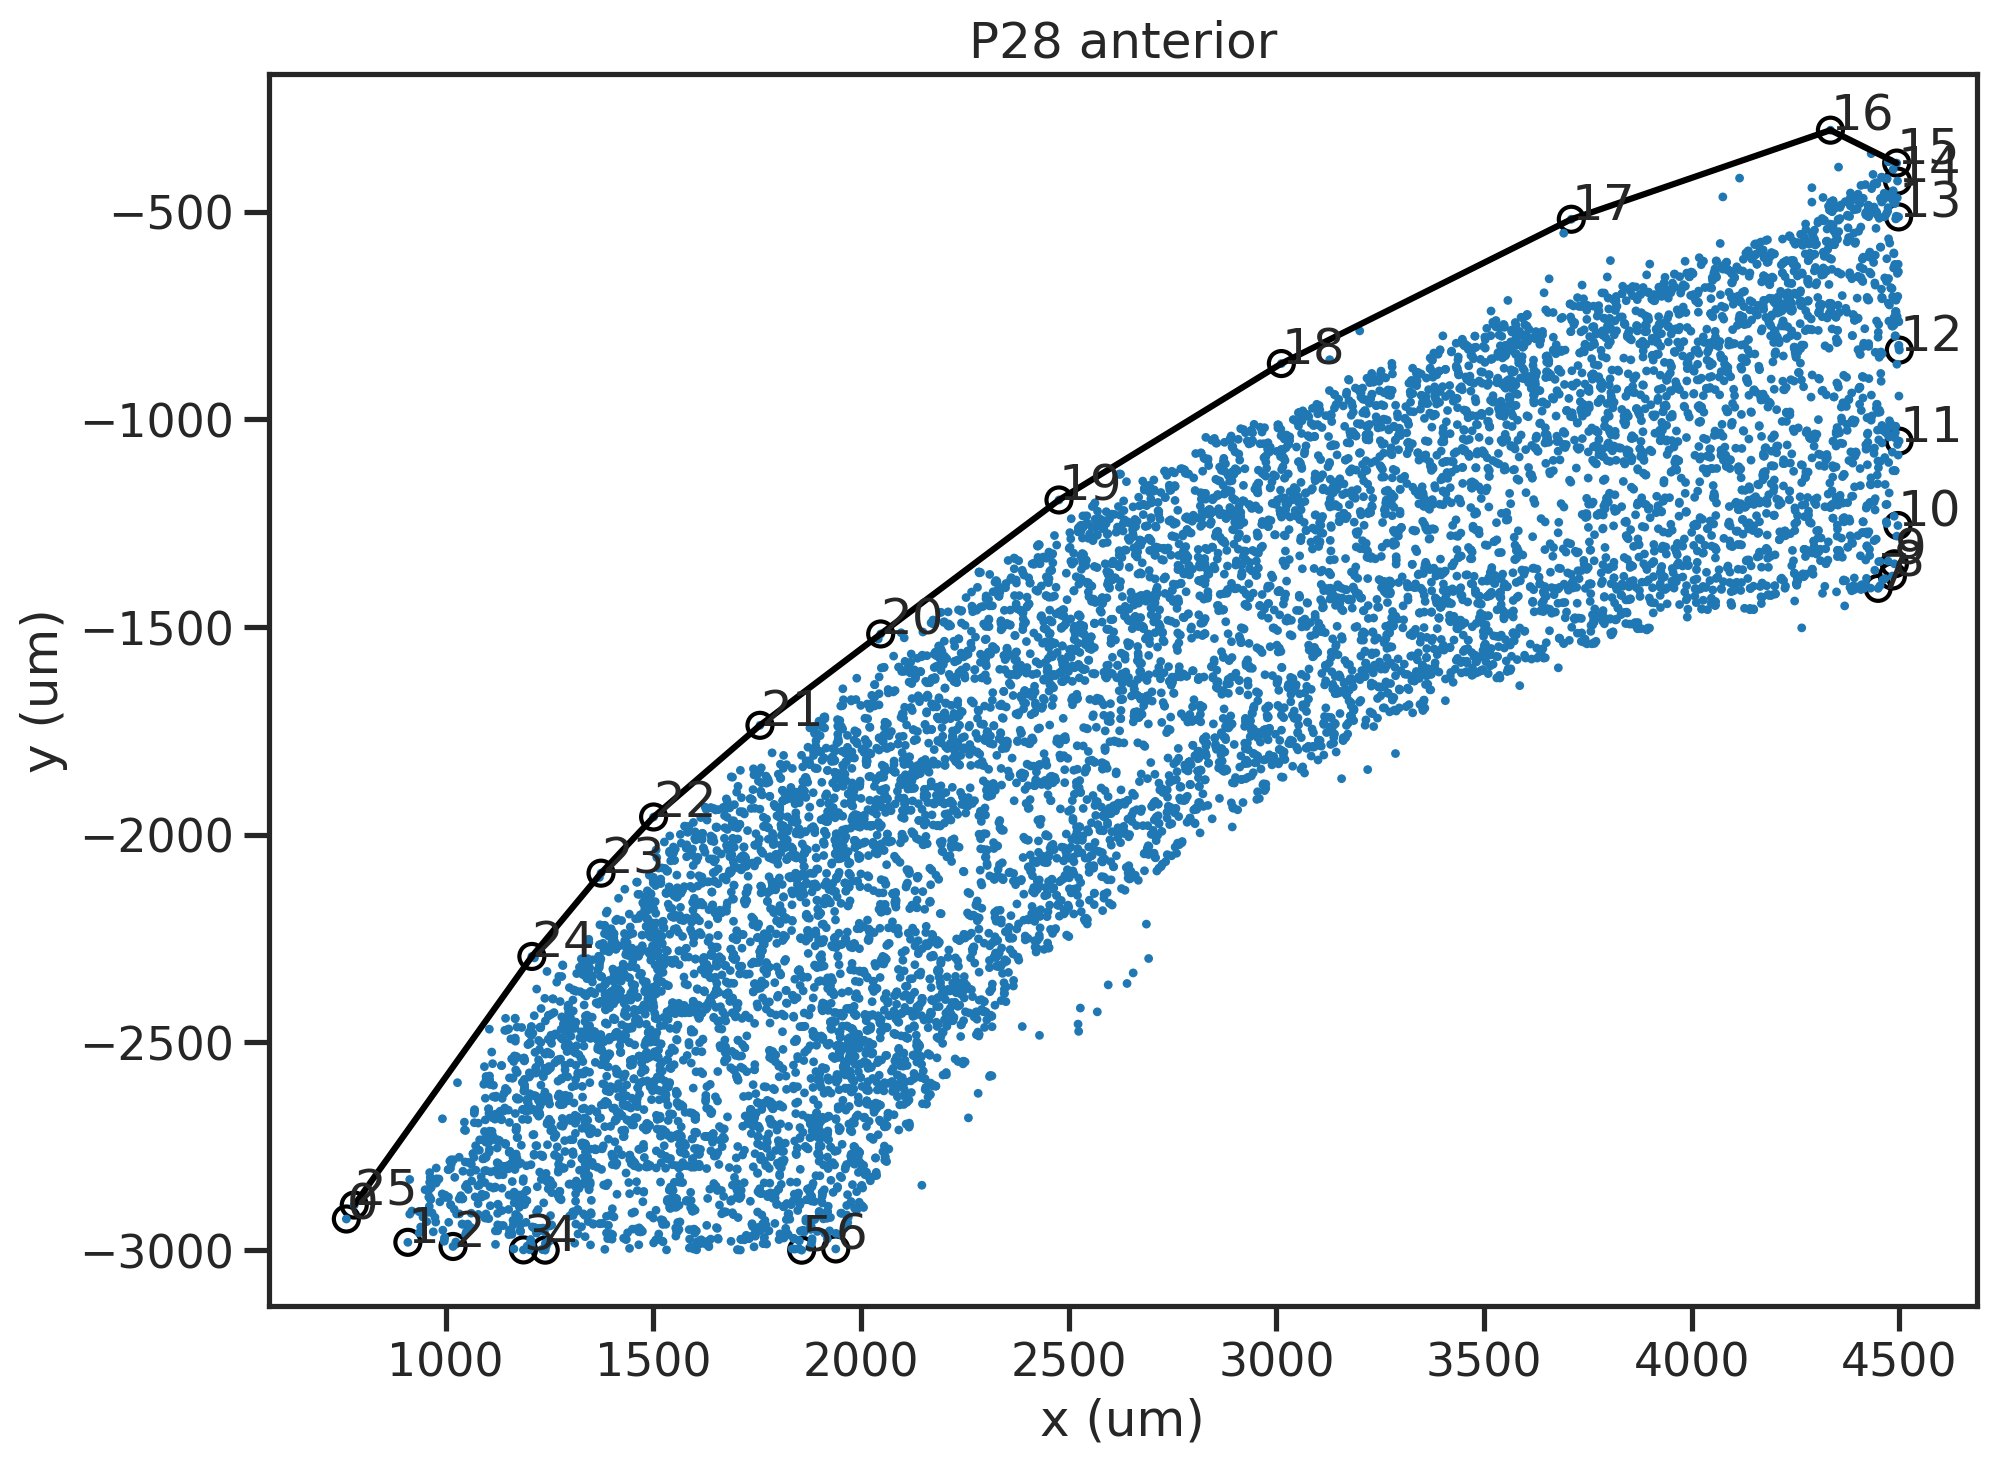

In [29]:
fig, ax = plt.subplots(figsize=(12,8))
for i, vtx in enumerate(hull.vertices):
    ax.scatter(XY[vtx, 0], XY[vtx, 1], facecolors='none', edgecolors='k')
    ax.text(XY[vtx, 0], XY[vtx, 1], i)
    
for i in range(len(pia_curve)-1):
    ax.plot(pia_curve[i:i+2, 0], 
            pia_curve[i:i+2, 1], 
            '-k')
    
sns.scatterplot(data=meta, x='x', y='y', 
                s=10, edgecolor='none', ax=ax)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')
ax.set_title(f'P28 anterior')

Text(0.5, 1.0, 'width')

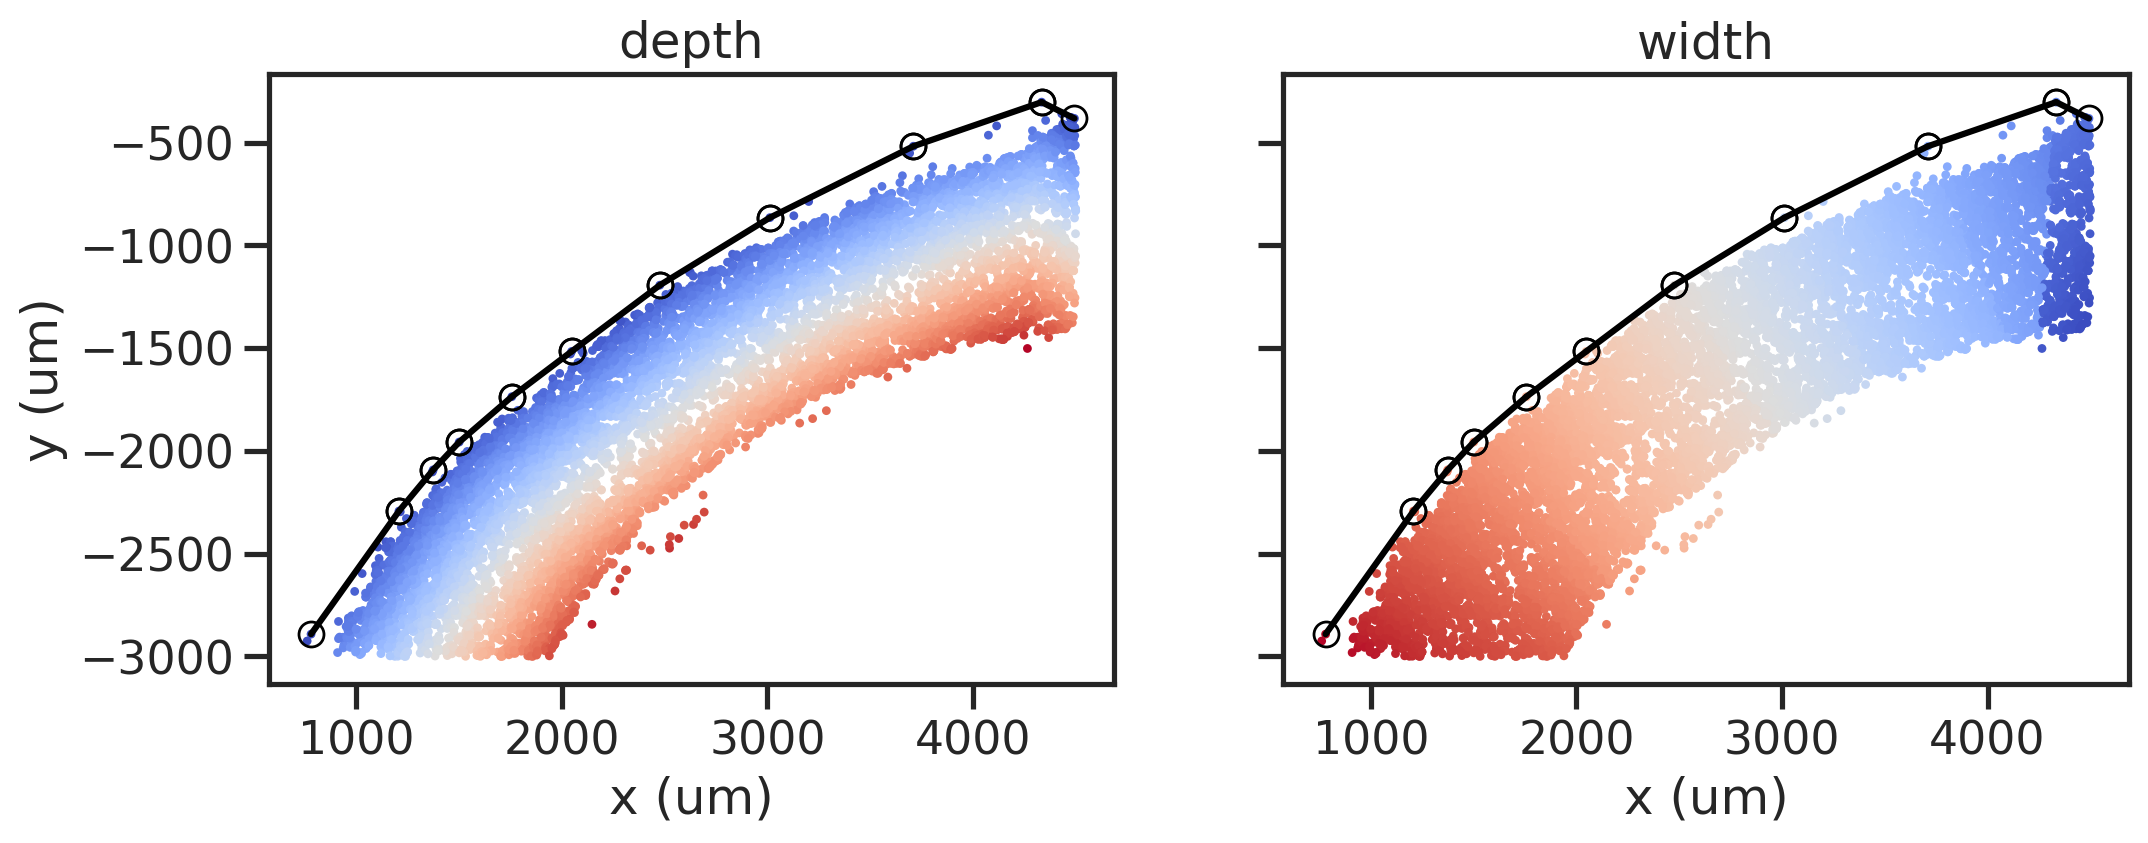

In [36]:
fig, axs = plt.subplots(1,2,figsize=(12,8*2), sharex=True, sharey=True)
ax = axs[0]
    
for i in range(len(pia_curve)-1):
    ax.plot(pia_curve[i:i+2, 0], 
            pia_curve[i:i+2, 1], 
            '-ok', fillstyle='none')
    
sns.scatterplot(data=meta, x='x', y='y', 
                hue='depth', 
                palette='coolwarm',
                legend=False,
                s=10, edgecolor='none', ax=ax)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')
ax.set_title(f'depth')

ax = axs[1]
for i in range(len(pia_curve)-1):
    ax.plot(pia_curve[i:i+2, 0], 
            pia_curve[i:i+2, 1], 
            '-ok', fillstyle='none')
    
sns.scatterplot(data=meta, x='x', y='y', 
                hue='width', 
                palette='coolwarm',
                legend=False,
                s=10, edgecolor='none', ax=ax)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')
ax.set_title(f'width')

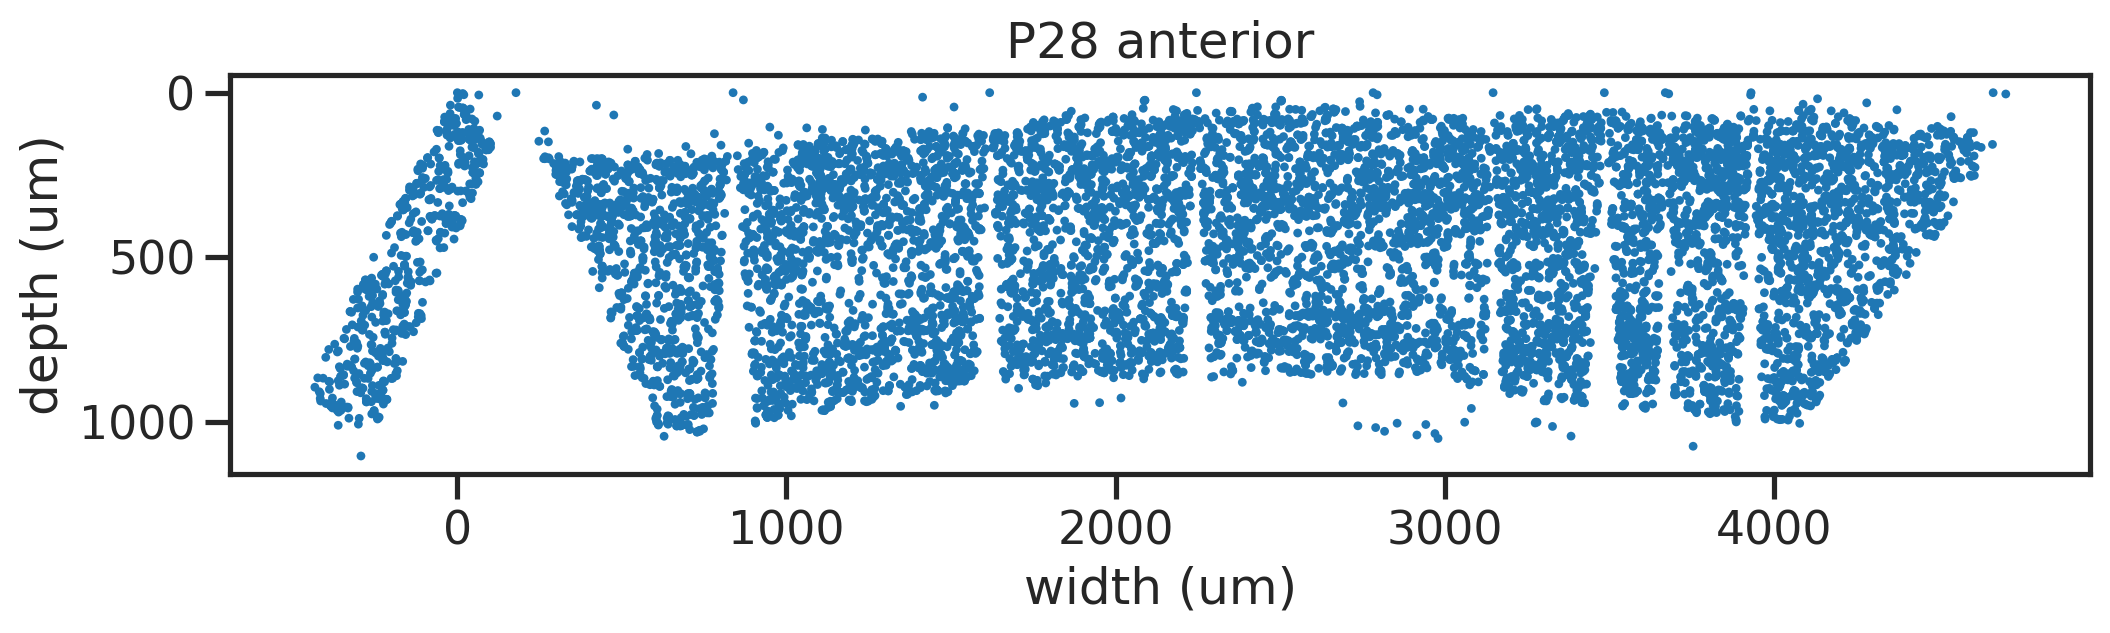

In [37]:
fig, ax = plt.subplots(1,1,figsize=(12,4*1))
sns.scatterplot(data=meta, x='width', y='depth', 
                # hue='width', 
                # palette='coolwarm',
                s=10, edgecolor='none', ax=ax)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('width (um)')
ax.set_ylabel('depth (um)')
ax.set_title(f'P28 anterior')
ax.invert_yaxis()
# ax.legend(bbox_to_anchor=(1,1))

In [17]:
genes = adata.var.index.values

In [18]:
easigenes = [
    'Adamts2',
    'Cdh13',
    'Sorcs3',
    'Chrm2',
    'Rorb',
    'Scnn1a',
    
    
    # 'Slc17a6',
    # 'Slc32a1',
    # 'Rspo1',
    # 'Lhx6',
    # 'Aqp4',
    # 'Sox10',
    # 'Flt1',
    
    # 'Cntn5',
    # 'Kcnip3',
    # 'Kcnq5',
]

easigenes = np.array([g for g in easigenes if g in genes])
easi_idx = basicu.get_index_from_array(genes, easigenes) 
easigenes, easi_idx, genes[easi_idx]

(array(['Adamts2', 'Cdh13', 'Sorcs3', 'Chrm2', 'Rorb', 'Scnn1a'],
       dtype='<U7'),
 array([401, 369, 255, 450, 351, 261]),
 array(['Adamts2', 'Cdh13', 'Sorcs3', 'Chrm2', 'Rorb', 'Scnn1a'],
       dtype=object))

In [19]:
meta[easigenes] = np.log10(1+np.array(adata[:,easi_idx].layers['norm']))
# meta[np.char.add(easigenes, '+')] = (meta[easigenes]>0).astype(int)
meta

x            y  gncov  fpcov             EntityID  fov  \
688      761.061657 -2924.948192     34      0  2595481500178100002  508   
694      780.117916 -2891.404674     99      1  2595481500178100012  508   
2099     913.635774 -2829.754494     76      1  2595481500229100040  508   
2144     918.780197 -2905.799607    172      0  2595481500230100023  507   
2147     936.495903 -2958.317502    628      4  2595481500230100027  507   
...             ...          ...    ...    ...                  ...  ...   
138947  4472.780184 -1341.286687    164      0  2595481501674100011  144   
138948  4483.028844 -1376.955677   1176      3  2595481501674100012  144   
138950  4487.808277 -1347.651398     78      2  2595481501674100015  144   
139052  4459.771367 -1386.880177     25      0  2595481501674100177  144   
139053  4465.006311 -1383.305234     12      0  2595481501674100178  144   

             volume     center_x     center_y        min_x  ...         depth  \
688      271.968972  2924.948192   761.061657  2920.926308  ...  3.990800e+00   
694     1493.535712  2891.404674   780.117916  2882.965410  ...  5.684342e-14   
2099    3406.719048  2829.754494   913.635774  2821.441491  ...  7.281204e+01   
2144     424.849902  2905.799607   918.780197  2896.290469  ...  1.211997e+02   
2147    1107.240125  2958.317502   936.495903  2945.741479  ...  1.661416e+02   
...             ...          ...          ...          ...  ...           ...   
138947   348.389409  1341.286687  4472.780184  1328.381208  ...  8.674959e+02   
138948   929.185678  1376.955677  4483.028844  1367.408832  ...  8.948836e+02   
138950   136.379330  1347.651398  4487.808277  1342.747659  ...  8.665119e+02   
139052    26.244849  1386.880177  4459.771367  1384.517964  ...  9.141171e+02   
139053    69.297716  1383.305234  4465.006311  1381.068629  ...  9.085868e+02   

              width           depth_bin             width_bin   Adamts2  \
688     4704.689593       (0.0, 58.098]   (4434.289, 4704.69]  0.000000   
694     4666.317961       (0.0, 58.098]   (4434.289, 4704.69]  0.000000   
2099    4538.544060   (58.098, 116.197]   (4434.289, 4704.69]  0.000000   
2144    4597.433442  (116.197, 174.295]   (4434.289, 4704.69]  0.000000   
2147    4629.871097  (116.197, 174.295]   (4434.289, 4704.69]  0.064172   
...             ...                 ...                   ...       ...   
138947  -407.868152  (813.379, 871.477]  (-432.913, -162.513]  0.000000   
138948  -432.912653  (871.477, 929.576]                   NaN  0.000000   
138950  -424.158788  (813.379, 871.477]  (-432.913, -162.513]  0.000000   
139052  -416.496928  (871.477, 929.576]  (-432.913, -162.513]  0.000000   
139053  -419.595380  (871.477, 929.576]  (-432.913, -162.513]  0.000000   

           Cdh13    Sorcs3     Chrm2  Rorb    Scnn1a  
688     0.000000  0.000000  0.000000   0.0  0.000000  
694     0.000000  0.000000  0.000000   0.0  0.000000  
2099    0.000000  0.000000  0.000000   0.0  0.000000  
2144    0.199040  0.000000  0.000000   0.0  0.000000  
2147    0.291239  0.000000  0.000000   0.0  0.000000  
...          ...       ...       ...   ...       ...  
138947  0.000000  0.000000  0.000000   0.0  0.000000  
138948  0.098679  0.127149  0.202826   0.0  0.068211  
138950  0.000000  0.000000  0.000000   0.0  0.000000  
139052  0.000000  0.000000  0.000000   0.0  0.000000  
139053  0.000000  0.000000  0.000000   0.0  0.000000  

[11615 rows x 35 columns]

In [38]:
# metasub
meta_mean  = meta.groupby(['depth_bin']).mean()[easigenes] # [np.hstack([easigenes, easigenes_p])]

/tmp/ipykernel_1876509/3545262021.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  meta_mean  = meta.groupby(['depth_bin']).mean()[easigenes] # [np.hstack([easigenes, easigenes_p])]


Adamts2 1043
Cdh13 3392
Sorcs3 1484
Chrm2 743
Rorb 1146
Scnn1a 749


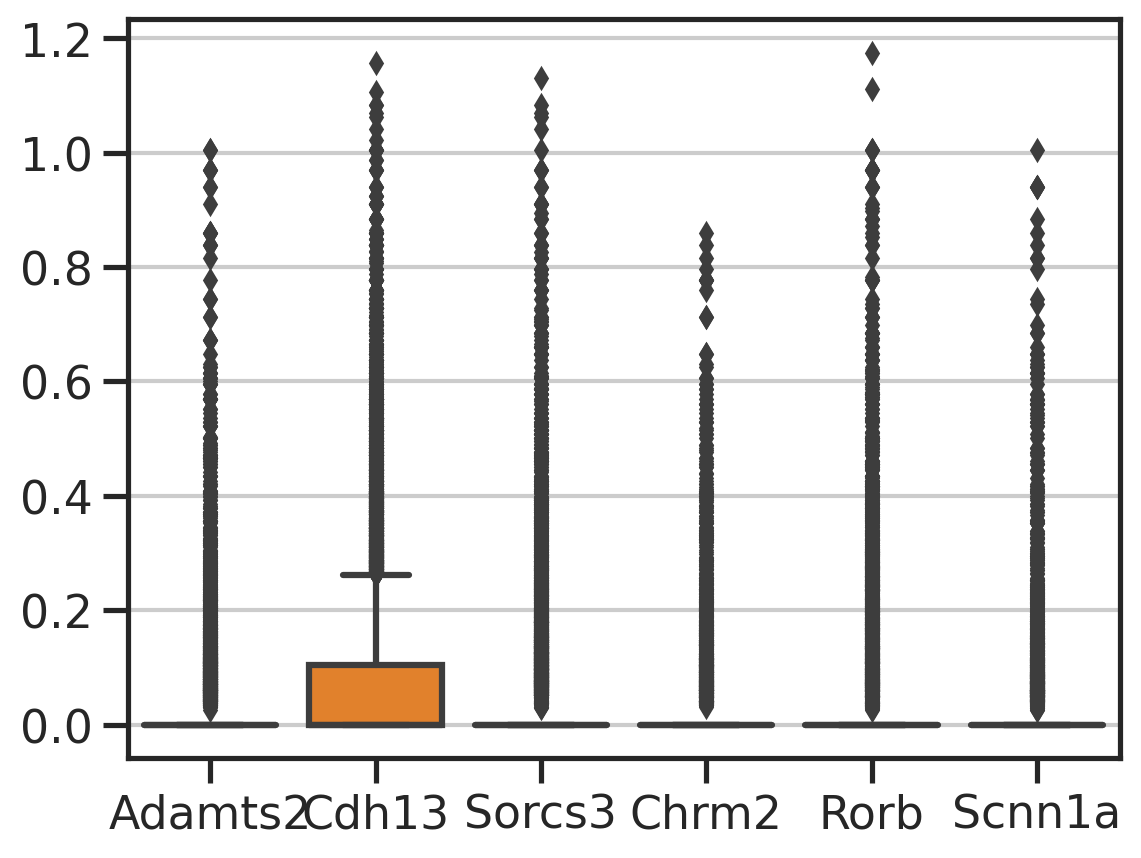

In [39]:
sns.boxplot(data=meta[easigenes])
for col in easigenes:
    print(col, (meta[col]>0).sum())

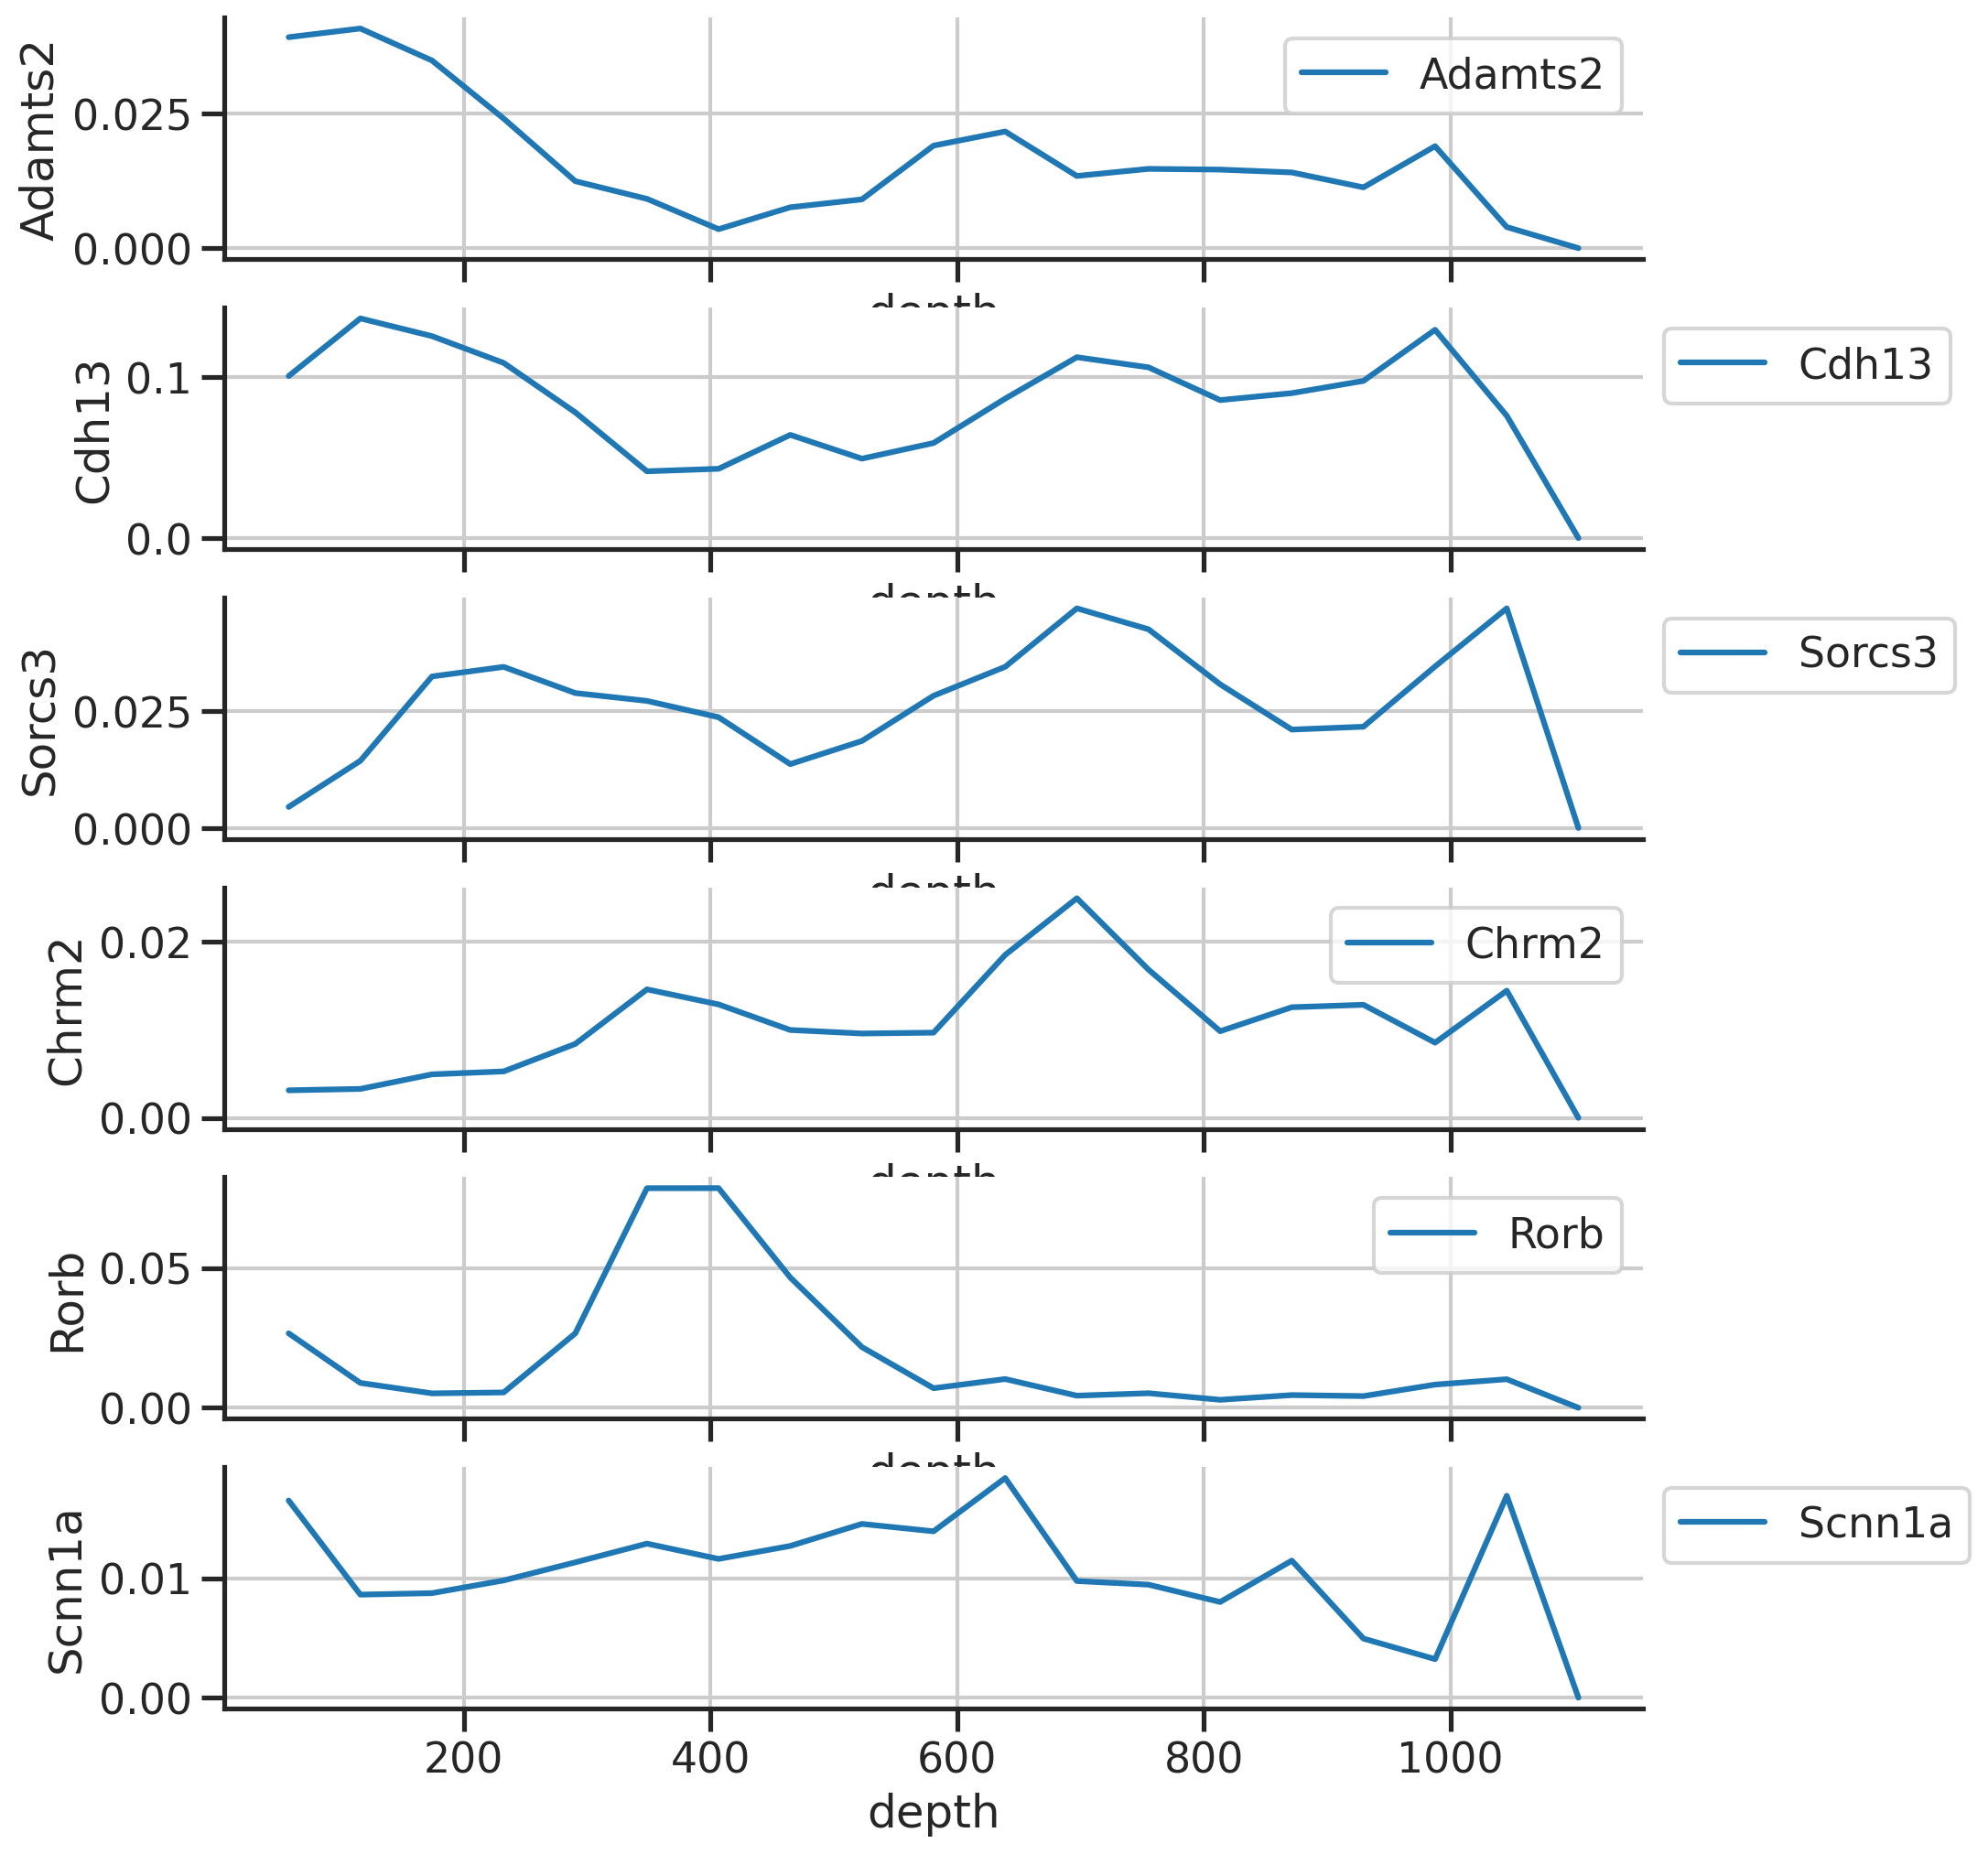

In [40]:
fig, axs = plt.subplots(len(easigenes), 1, figsize=(10,2*len(easigenes)), sharex=True)
for col, ax in zip(easigenes, axs): #metasub_typefrac_perbin: 
    ax.plot(depth_bins[1:], meta_mean[col].values, label=col) #, color=palette[col])
    ax.legend(bbox_to_anchor=(1,1))
    sns.despine(ax=ax)
    ax.set_xlabel('depth')
    ax.set_ylabel(col)
    
# fig, axs = plt.subplots(4, 1, figsize=(10,4*4), sharex=True)
# for col, ax in zip(easigenes_p, axs): #metasub_typefrac_perbin: 
#     ax.plot(pia_bins[1:], meta_mean[col].values, label=col) #, color=palette[col])
#     ax.legend(bbox_to_anchor=(1,1))
#     sns.despine(ax=ax)
#     ax.set_xlabel('Pia depth')
#     ax.set_ylabel(col)

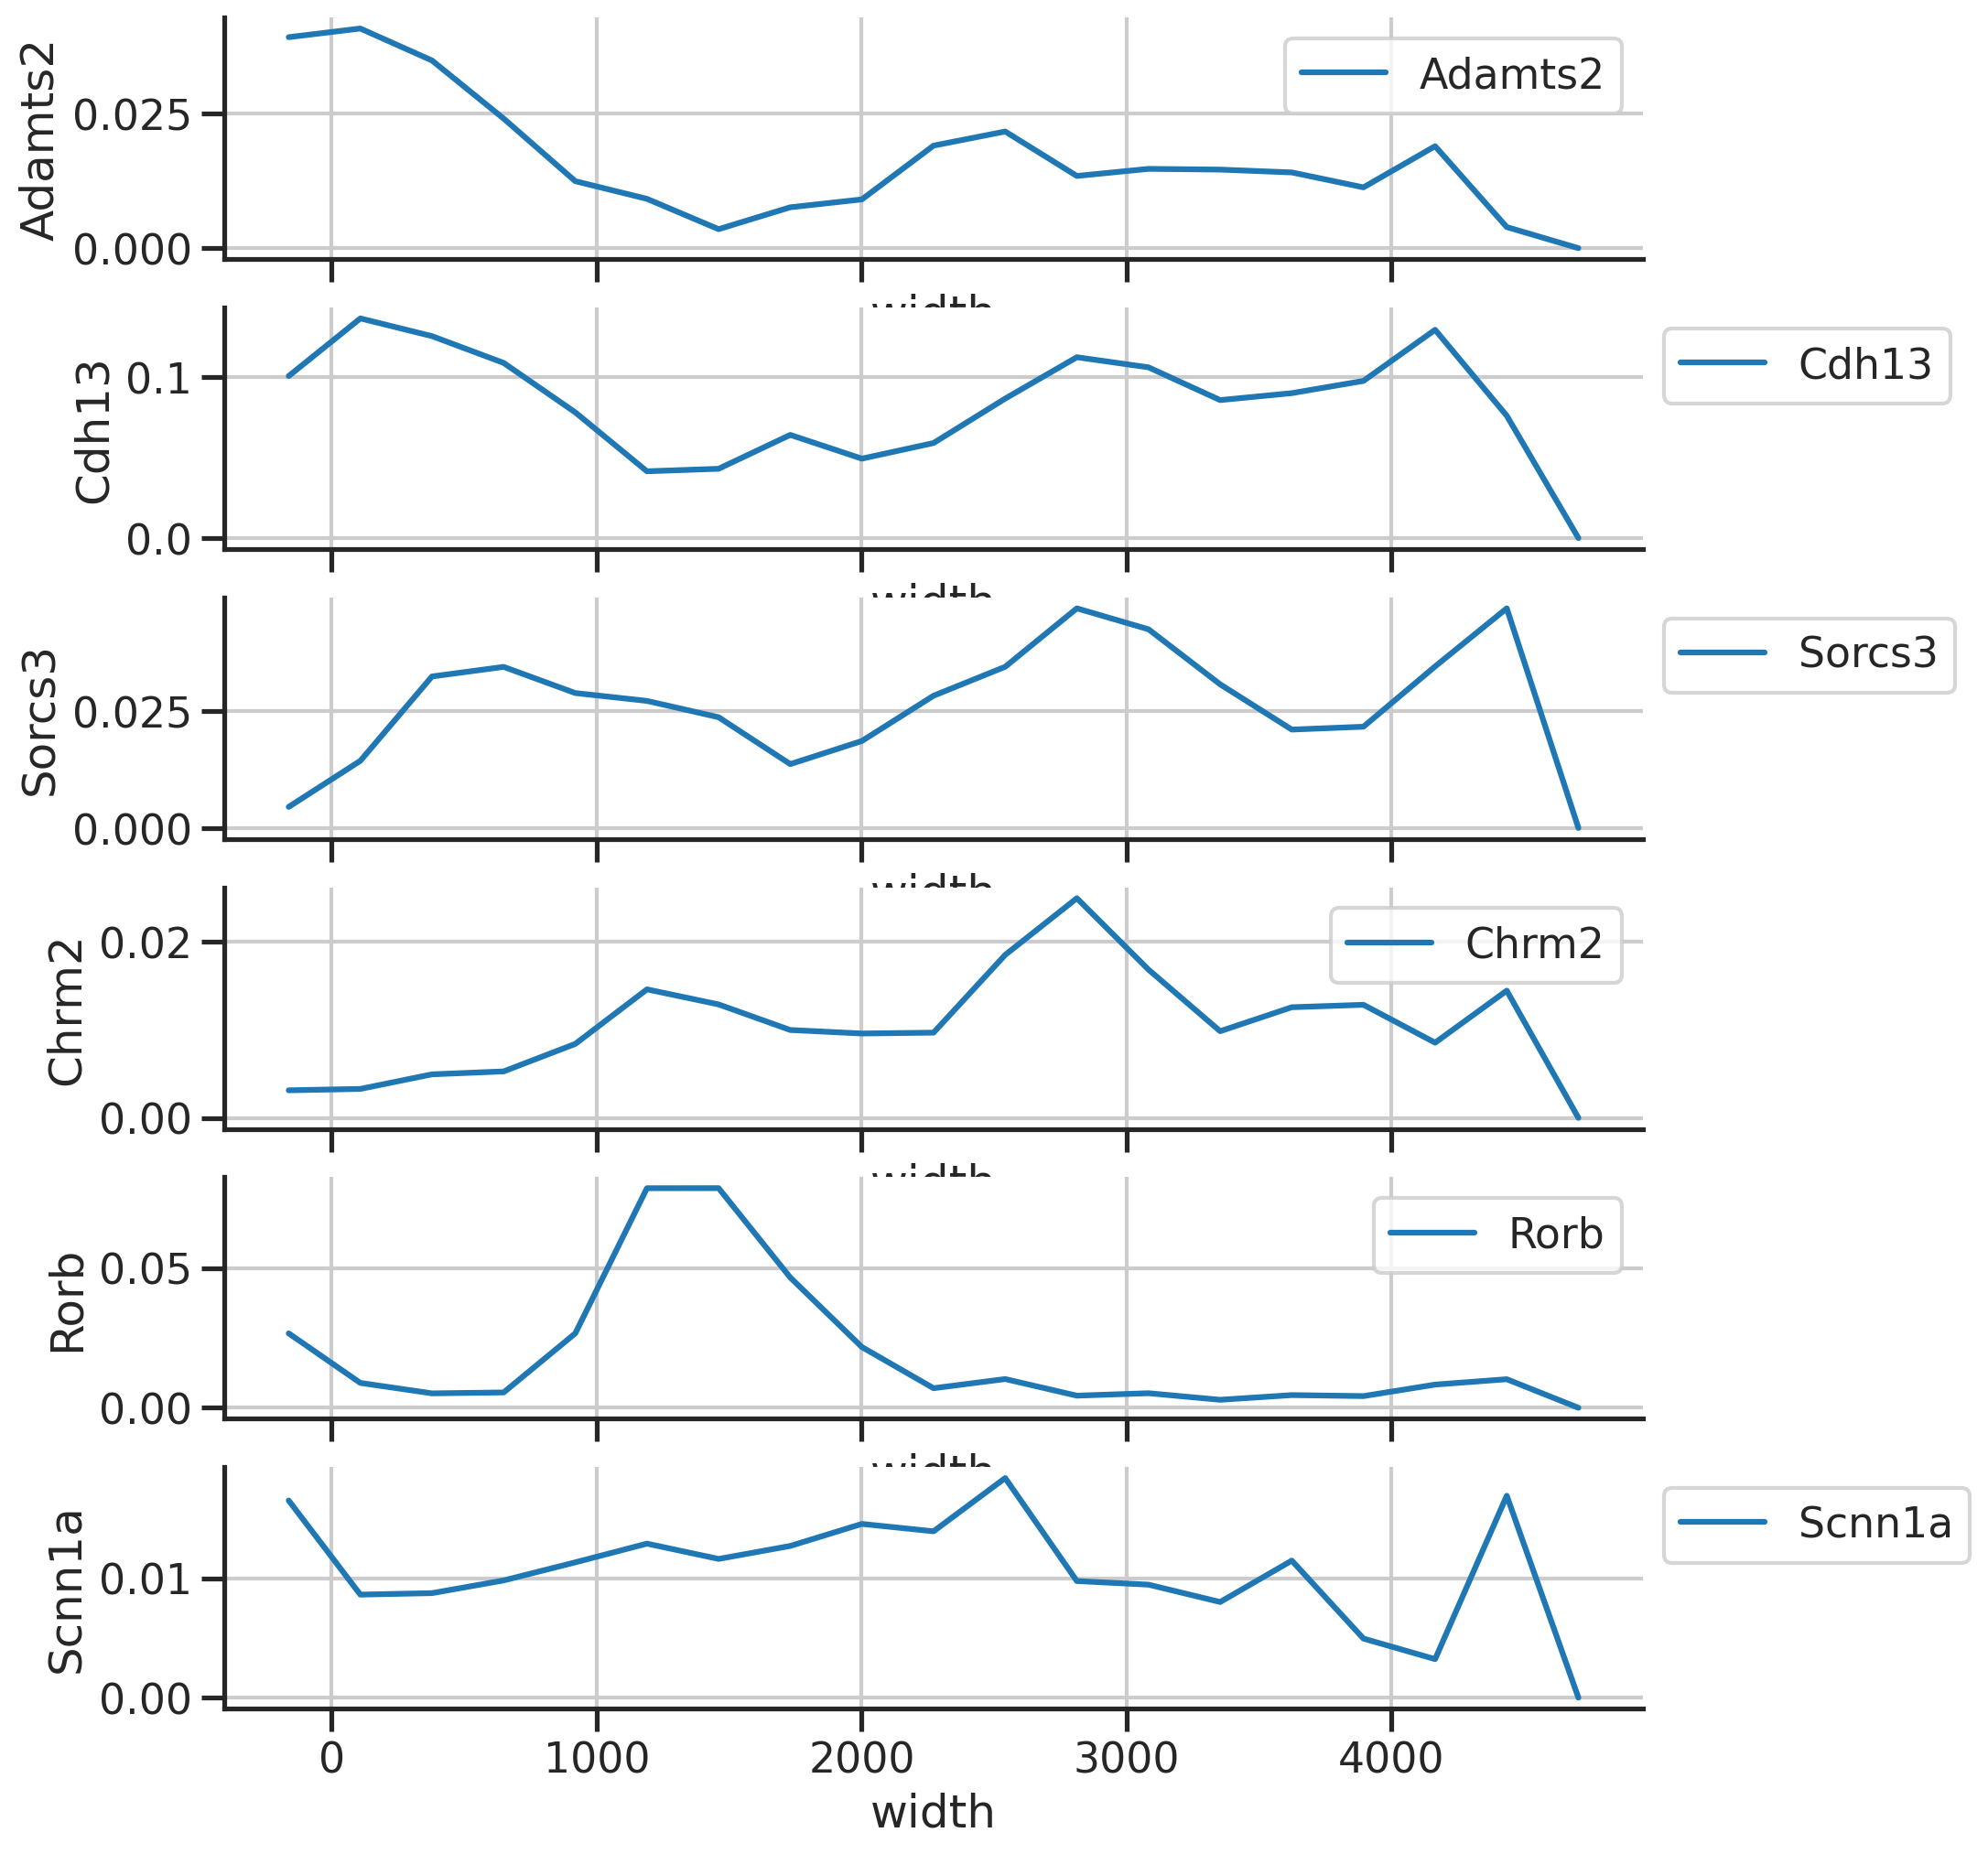

In [41]:
fig, axs = plt.subplots(len(easigenes), 1, figsize=(10,2*len(easigenes)), sharex=True)
for col, ax in zip(easigenes, axs): #metasub_typefrac_perbin: 
    ax.plot(width_bins[1:], meta_mean[col].values, label=col) #, color=palette[col])
    ax.legend(bbox_to_anchor=(1,1))
    sns.despine(ax=ax)
    ax.set_xlabel('width')
    ax.set_ylabel(col)

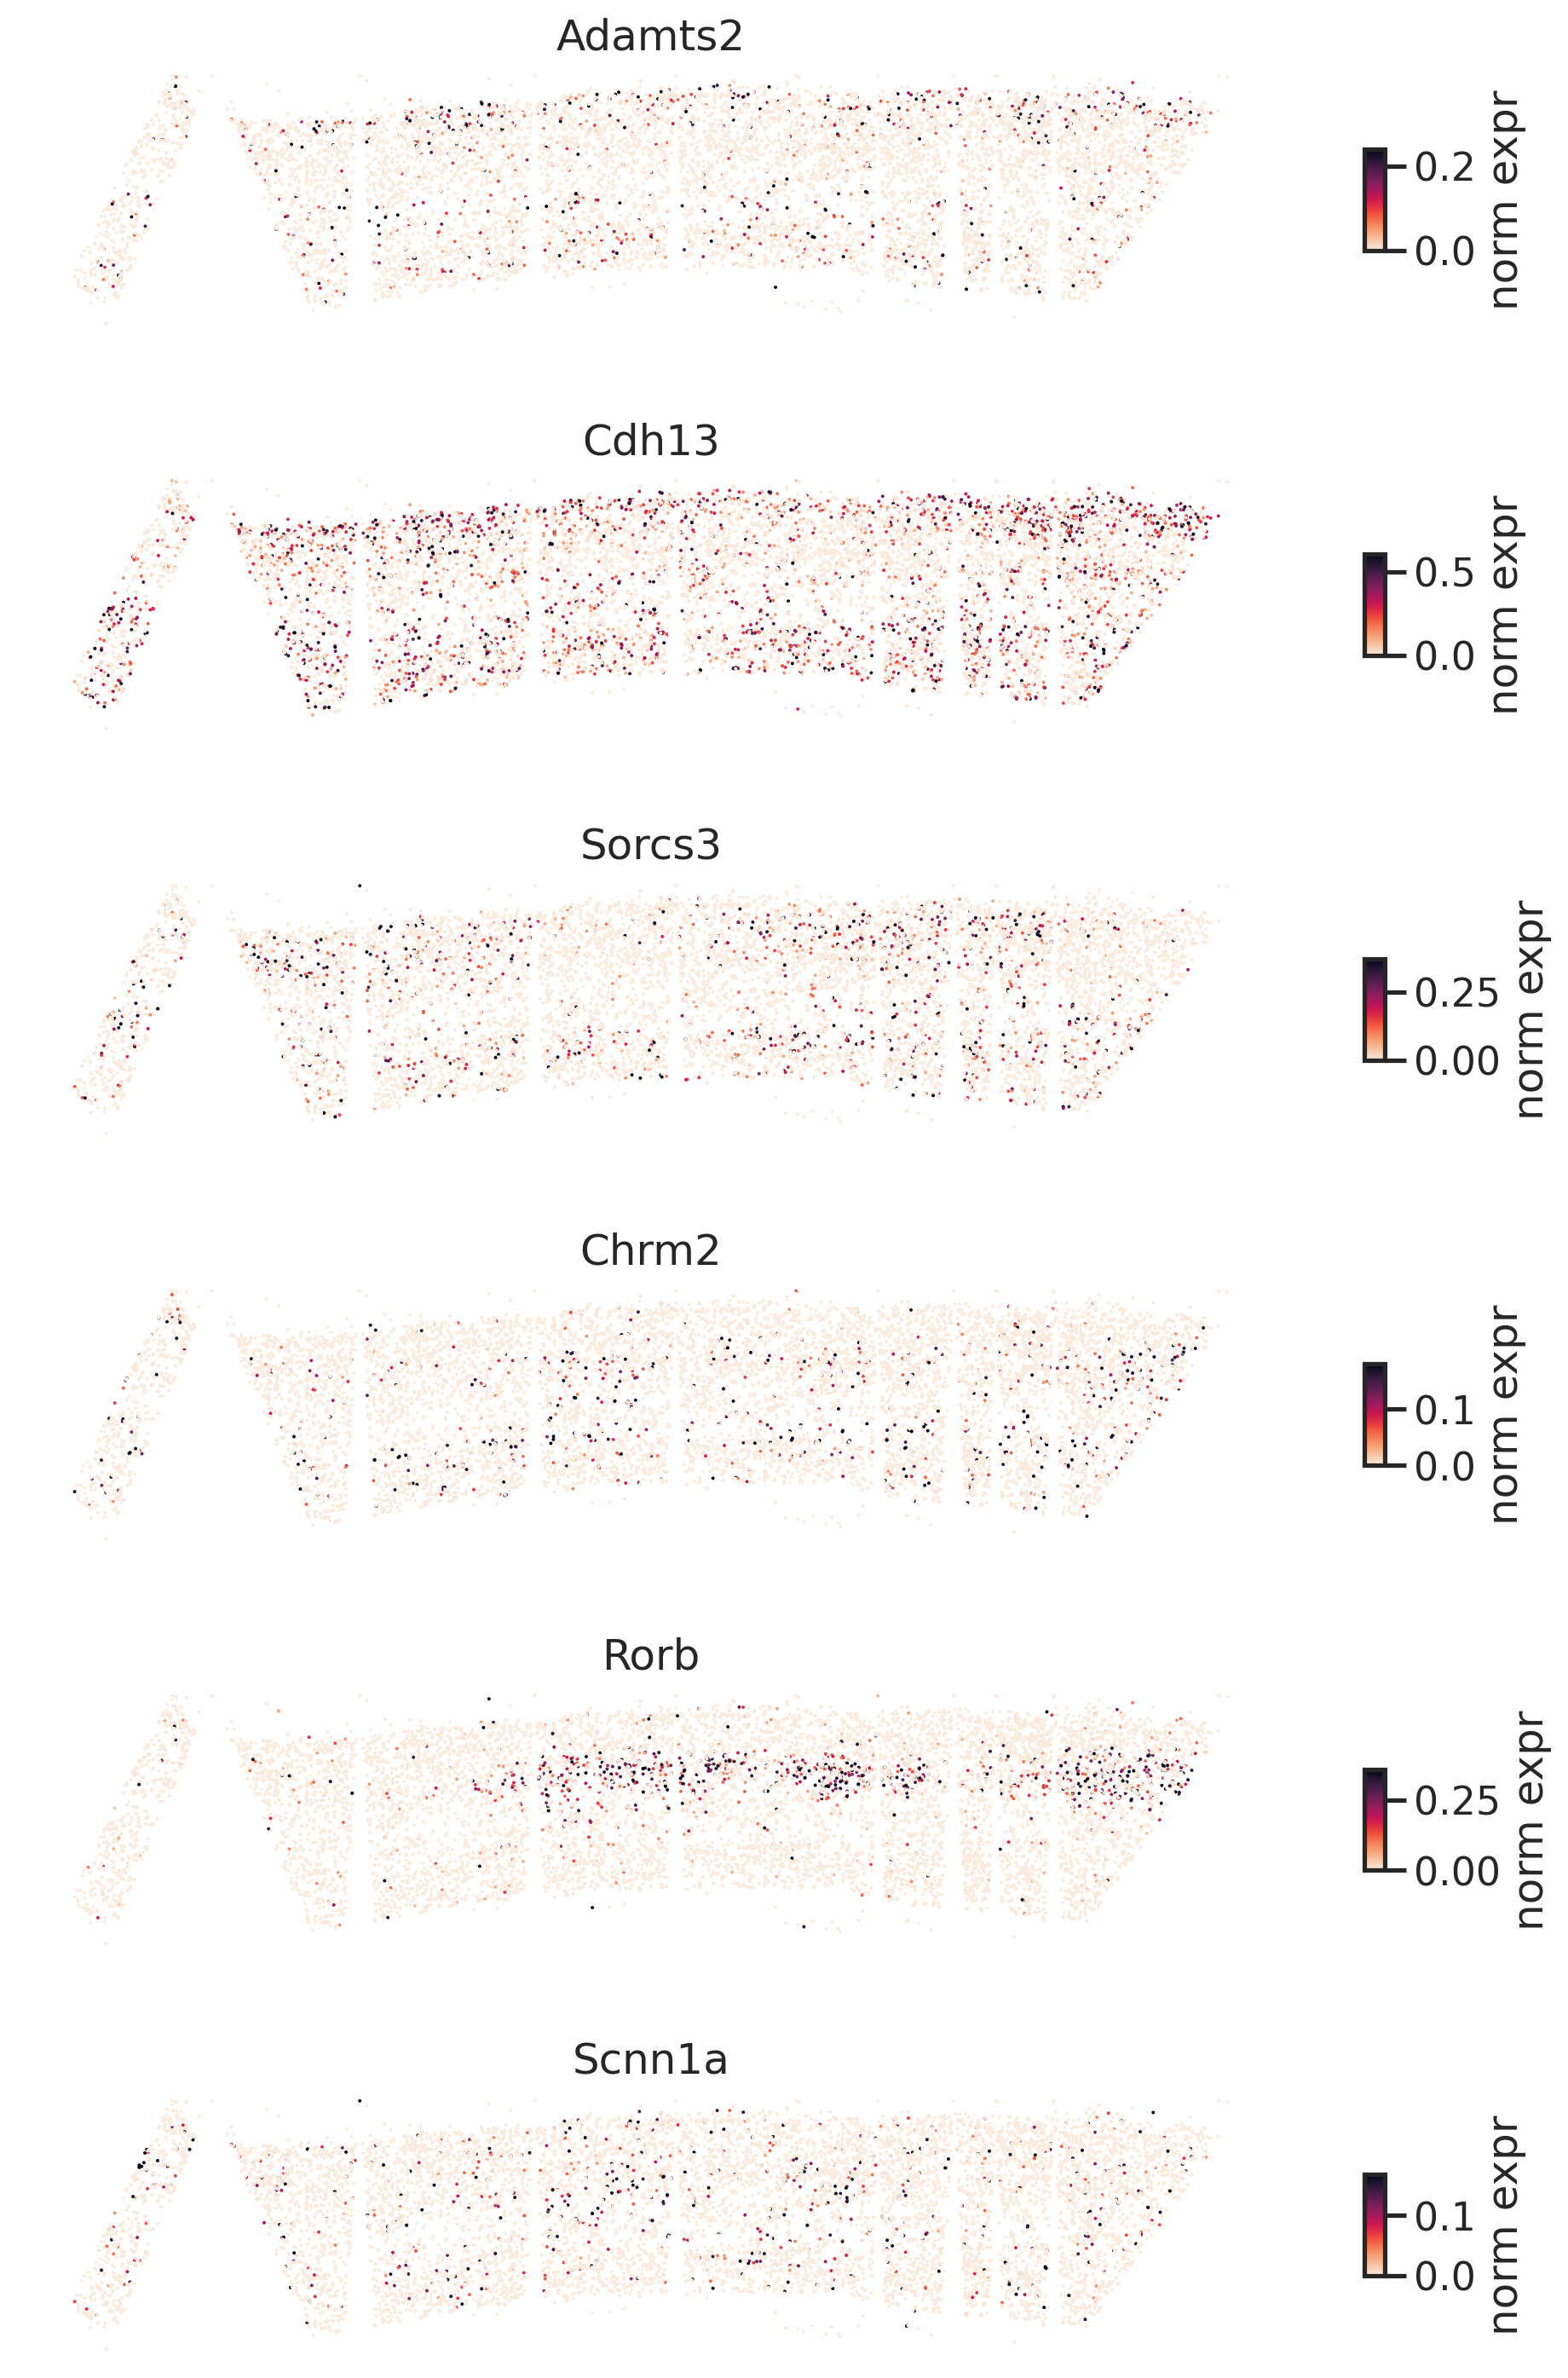

In [42]:
n = len(easigenes)
fig, axs = plt.subplots(n,1,figsize=(12,3*n))
for col, ax in zip(
                   easigenes, 
                   # easigenes_p, 
                   axs):
    
    x = meta['width'].values
    y = meta['depth'].values
    c = meta[col].values
    vmax=np.percentile(c, 98)
    
    g = ax.scatter(x, y, c=c, s=2, edgecolor='none', vmax=vmax, vmin=0, cmap='rocket_r')
    
    ax.axis('off')
    ax.set_aspect('equal')
    ax.set_xlabel('x (um)')
    ax.set_ylabel('y (um)')
    ax.set_title(col)
    ax.invert_yaxis() # no share x y
    fig.colorbar(g, ax=ax, label='norm expr', aspect=5, shrink=0.3)

# cortical areas
- where are visual ctx? where are V1?


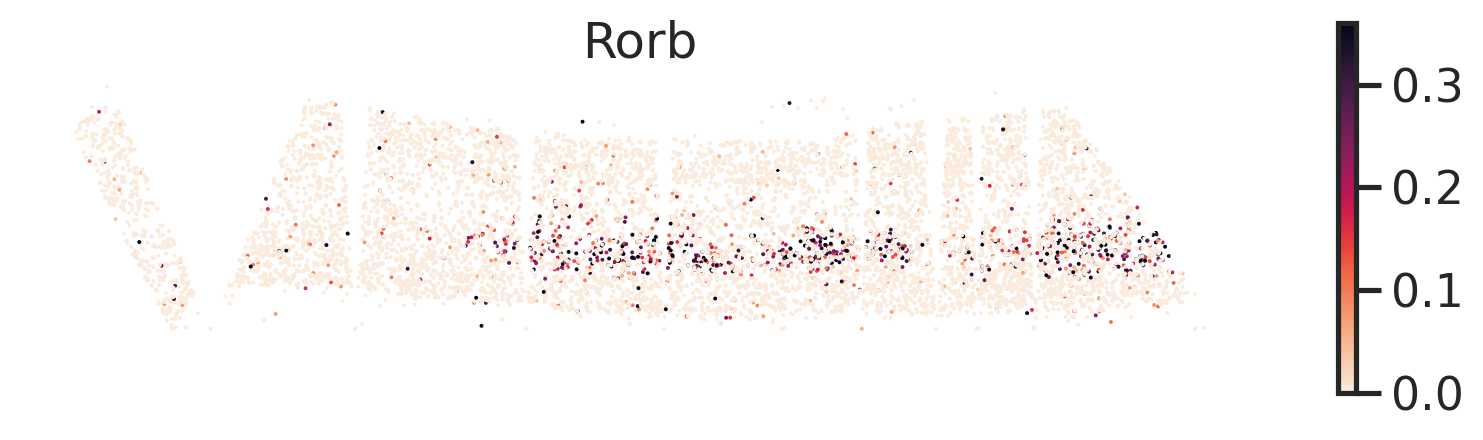

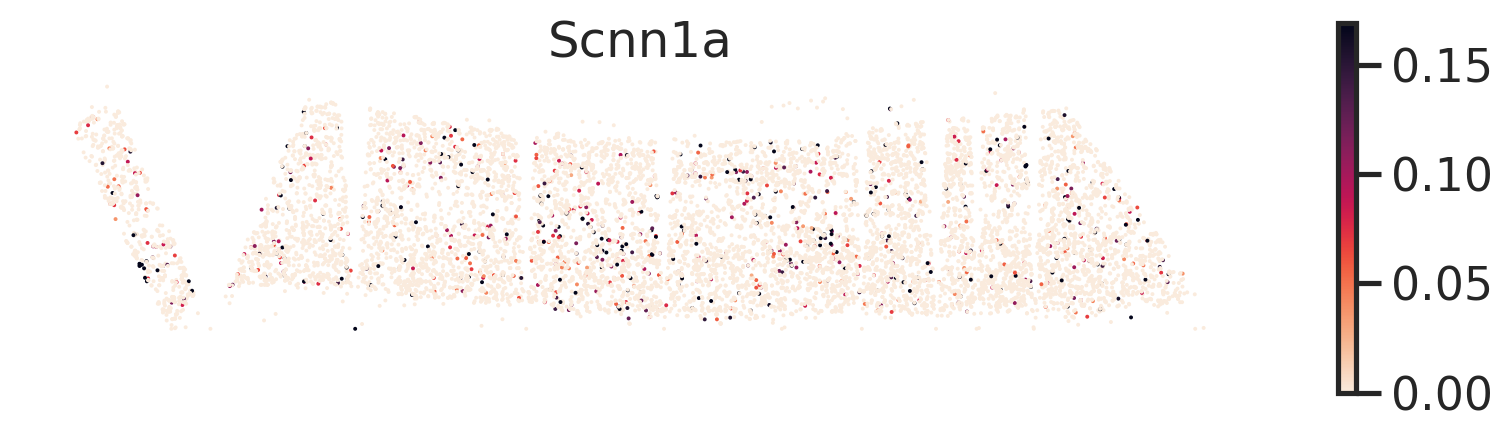

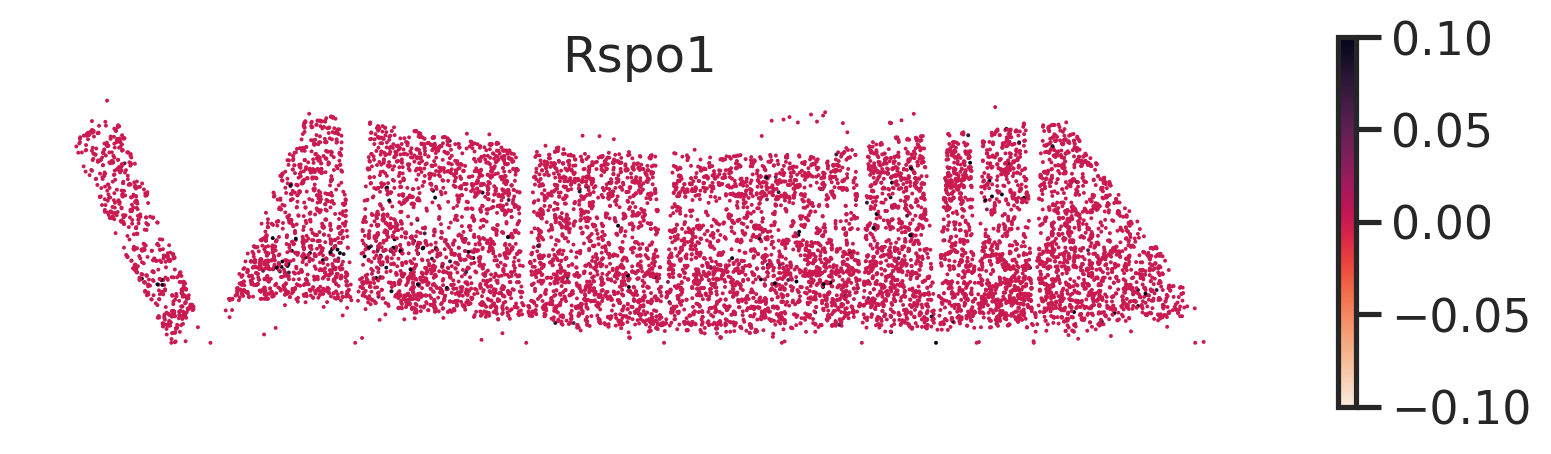

In [43]:
gns = [
    # chou 13
    'Rorb', # +
#     'Igfbp5', # +
#     'Igfbp4', # -
#     'Cdh8', # -
#     'Lmo4', # -
    
#     # # Vue 13
#     # 'Id2', # -
    
    # Vincent - L4
    'Scnn1a', 
    'Rspo1',
]

for gn in gns:
    depths = meta['depth']
    widths = meta['width']
    g = np.log10(1+adata[:,gn].layers['norm'])
    # st_scatter(x, y, gexp=g, s=2, title=gn)
    st_scatter(widths, depths, gexp=g, s=2, title=gn)
    plt.show()
    # plt.close()
    # st_scatter(ux, uy, gexp=g, s=2, title=gn)

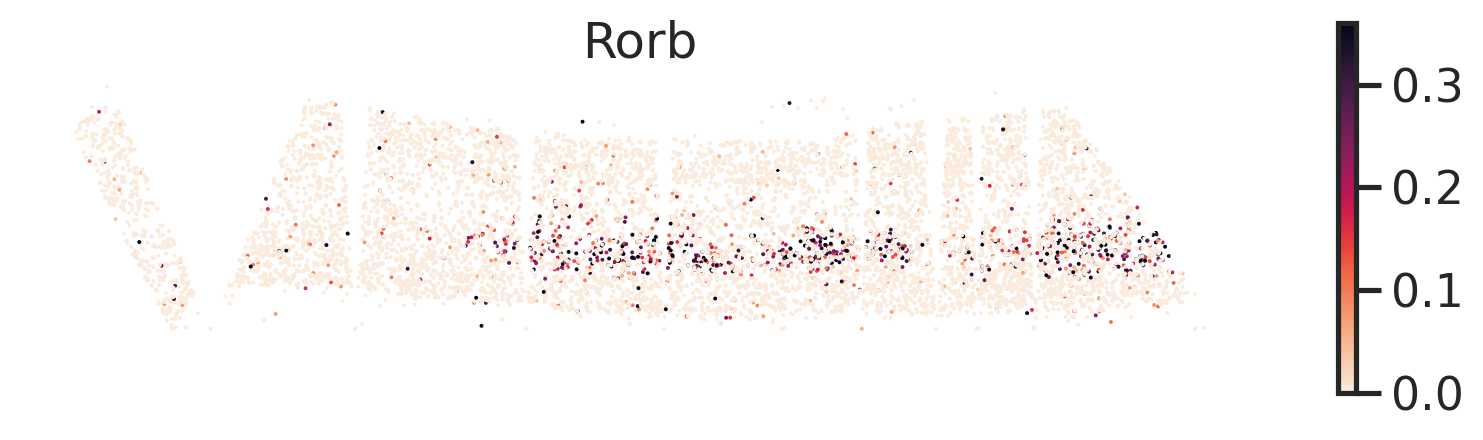

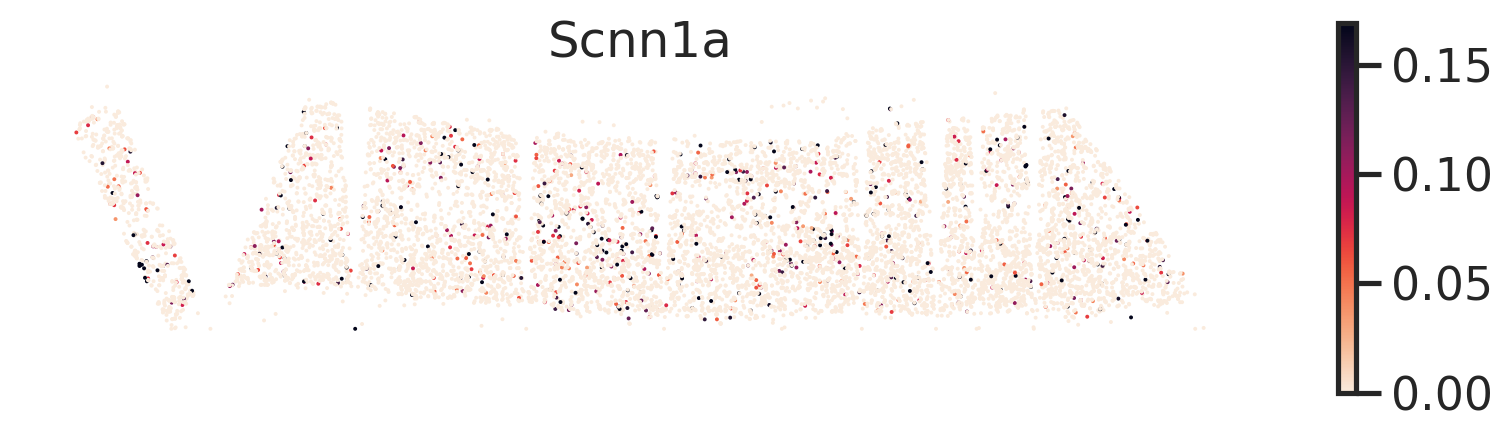

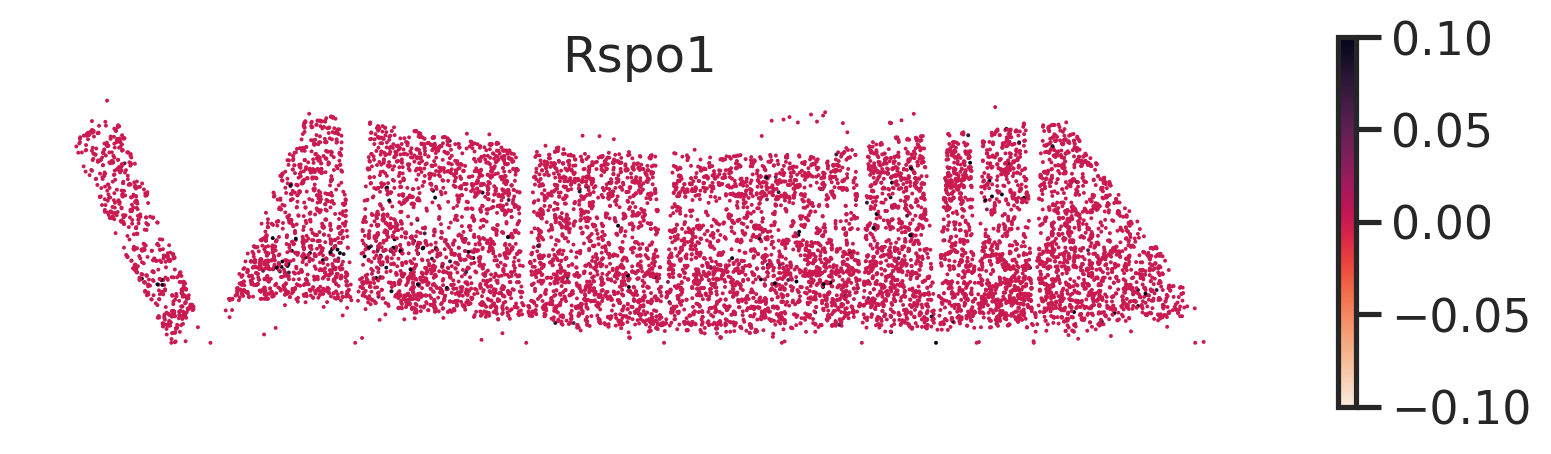

In [44]:
gns = [
    # chou 13
    'Rorb', # +
#     'Igfbp5', # +
#     'Igfbp4', # -
#     'Cdh8', # -
#     'Lmo4', # -
    
#     # # Vue 13
#     # 'Id2', # -
    
    # Vincent - L4
    'Scnn1a', 
    'Rspo1',
]

for gn in gns:
    g = np.log10(1+adata[:,gn].layers['norm'])
    st_scatter(x, y, gexp=g, s=2, title=gn)
    plt.show()
    # plt.close()
    # st_scatter(ux, uy, gexp=g, s=2, title=gn)

In [ ]:
gns = [
    # 'Astn2',
    # 'Ntn4',
    # 'Nefm',
    # 'Cadps2',
    # 'Hunk',
    # 'Shisa6',
    # 'Syt10',
    # 'Syt17',
    # 'Plxnd1',
    # 'Meis2',
    # 'Epha6',
    # 'Cdh4',
    # 'Ldb2',
    # 'Col26a1',
    # 'Nell1',
    # 'Sorcs3',
    # 'Brinp3',
    # 'Mkx',
    'Tshz1',
]

for gn in gns:
    g = np.log10(1+adata[:,gn].layers['norm'])
    st_scatter(x, y, gexp=g, s=2, title=gn)
    plt.show()
    # plt.close()
    # st_scatter(ux, uy, gexp=g, s=2, title=gn)

# all ABC genes in order

In [ ]:
f = '/data/qlyu/v1/results/MERFISH_gene_panel_Version1_March9.csv'
df = pd.read_csv(f)
f = '/data/qlyu/v1/results/gene_ptime_P28_L23_Mar27.tsv'
df2 = pd.read_csv(f).sort_values('gene_ptime')
df = pd.merge(df, df2, left_on='gene_name_data', right_on='gene').sort_values('gene_ptime')
genes_abco = df['gene_name_vizgen'].values
genes_abco.shape

# Merge A,B,C

In [ ]:
adata_a = adata[:,df[df['P17on_x']=='A']['gene_name_vizgen']]
g = np.sum(adata_a.layers['norm'], axis=1)
st_scatter(x, y, gexp=g, s=2, title=f'A markers (n={adata_a.shape[1]})', cmap='coolwarm', format='{x:.1f}')

adata_b = adata[:,df[df['P17on_x']=='B']['gene_name_vizgen']]
g = np.sum(adata_b.layers['norm'], axis=1)
st_scatter(x, y, gexp=g, s=2, title=f'B markers (n={adata_b.shape[1]})', cmap='coolwarm', format='{x:.1f}')

adata_c = adata[:,df[df['P17on_x']=='C']['gene_name_vizgen']]
g = np.sum(adata_c.layers['norm'], axis=1)
st_scatter(x, y, gexp=g, s=2, title=f'C markers (n={adata_c.shape[1]})', cmap='coolwarm', format='{x:.1f}')

In [ ]:
from scipy.stats import zscore

In [ ]:
for cat in ['A', 'B', 'C']:
    adata_ = adata[:,df[df['P17on_x']==cat]['gene_name_vizgen']]
    g = np.mean(zscore(np.log10(1+np.array(adata_.layers['norm'])), axis=0), axis=1)
    st_scatter(x, y, gexp=g, s=2, title=f'{cat} markers (n={adata_.shape[1]})', cmap='coolwarm', format='{x:.1f}')

In [ ]:
# !rm $outdir/*

In [ ]:
# for i, gn in enumerate(genes_abco):
#     g = np.log10(1+adata[:,gn].layers['norm'])
#     title = f'{i:03d}_{gn}'
#     output = outdir+f"/{title}.pdf"
#     print(output)
#     st_scatter(x, y, gexp=g, s=2, title=title, format='{x:.2f}', vmin=0, unit_norm=True, output=output)
#     # plt.show()
#     plt.close()
#     # st_scatter(ux, uy, gexp=g, s=2, title=gn)
#     # break

# layer specificity 

In [ ]:
# gns = [
#     'Cux2',
#     'Rorb',
#     'Whrn',
# ]

# for gn in gns:
#     g = np.log10(1+adatasub5[:,gn].layers['norm'])
#     st_scatter(x, y, gexp=g, s=2, title=gn)
#     plt.show()
#     # plt.close()
#     # st_scatter(ux, uy, gexp=g, s=2, title=gn)

In [ ]:
# gns = [
#     'Cdh13',
#     'Adamts2',
#     'Nr4a3',
#     'Cntn5',
#     'Gabrg3',
#     'Grm8',
#     'Sorcs3',
#     'Chrm2',
#     'Cdh12',
#     'Cntnap2',
#     'Kcnh5',
#     'Kcnq5',
#     'Ncam2',
#     'Gria3',
#     'Rorb',
#     'Kcnip3',
#     'Baz1a',
#     'Rfx3',
#     'Trpc6',
#     'Egfem1',
#     'Igfn1',
#     'Bdnf',
#     'Epha3',
#     'Kcna1',
#     'Whrn',
#     'Igsf9b',
#     'Mdga1',
# ]

# for gn in gns:
#     g = np.log10(1+adatasub5[:,gn].layers['norm'])
#     st_scatter(x, y, gexp=g, s=2, title=gn)
#     plt.show()
#     # plt.close()
#     # st_scatter(ux, uy, gexp=g, s=2, title=gn)